In [ ]:
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import os

file_pattern = "/Users/bhupendra/projects/crocus/data/flux_data/data/netcdf/resnc/2024??/*.nc"
ds = xr.open_mfdataset(file_pattern, combine='by_coords')

time = pd.to_datetime(ds['time'].values, unit='s')

df = pd.DataFrame({
    'time': time,
    'H': ds['H'].values,  
    'LE': ds['LE'].values,  
    'H2O_flux': ds['h2o_flux'].values, 
    'CO2_flux': ds['co2_flux'].values, 
    'wind_speed': ds['wind_speed'].values, 
    'wind_dir': ds['wind_dir'].values,  
    'w_rot': ds['w_rot'].values  
})

df['time'] = time.tz_localize('UTC').tz_convert('America/Chicago')

df['time_of_day'] = df['time'].dt.strftime('%H:%M')

diurnal_means = df.groupby('time_of_day').mean()

diurnal_means = diurnal_means.sort_index()

units = {
    'H': ds['H'].units if 'units' in ds['H'].attrs else '',
    'LE': ds['LE'].units if 'units' in ds['LE'].attrs else '',
    'H2O_flux': ds['h2o_flux'].units if 'units' in ds['h2o_flux'].attrs else '',
    'CO2_flux': ds['co2_flux'].units if 'units' in ds['co2_flux'].attrs else '',
    'wind_speed': ds['wind_speed'].units if 'units' in ds['wind_speed'].attrs else 'm/s',
    'wind_dir': ds['wind_dir'].units if 'units' in ds['wind_dir'].attrs else 'degrees'
}


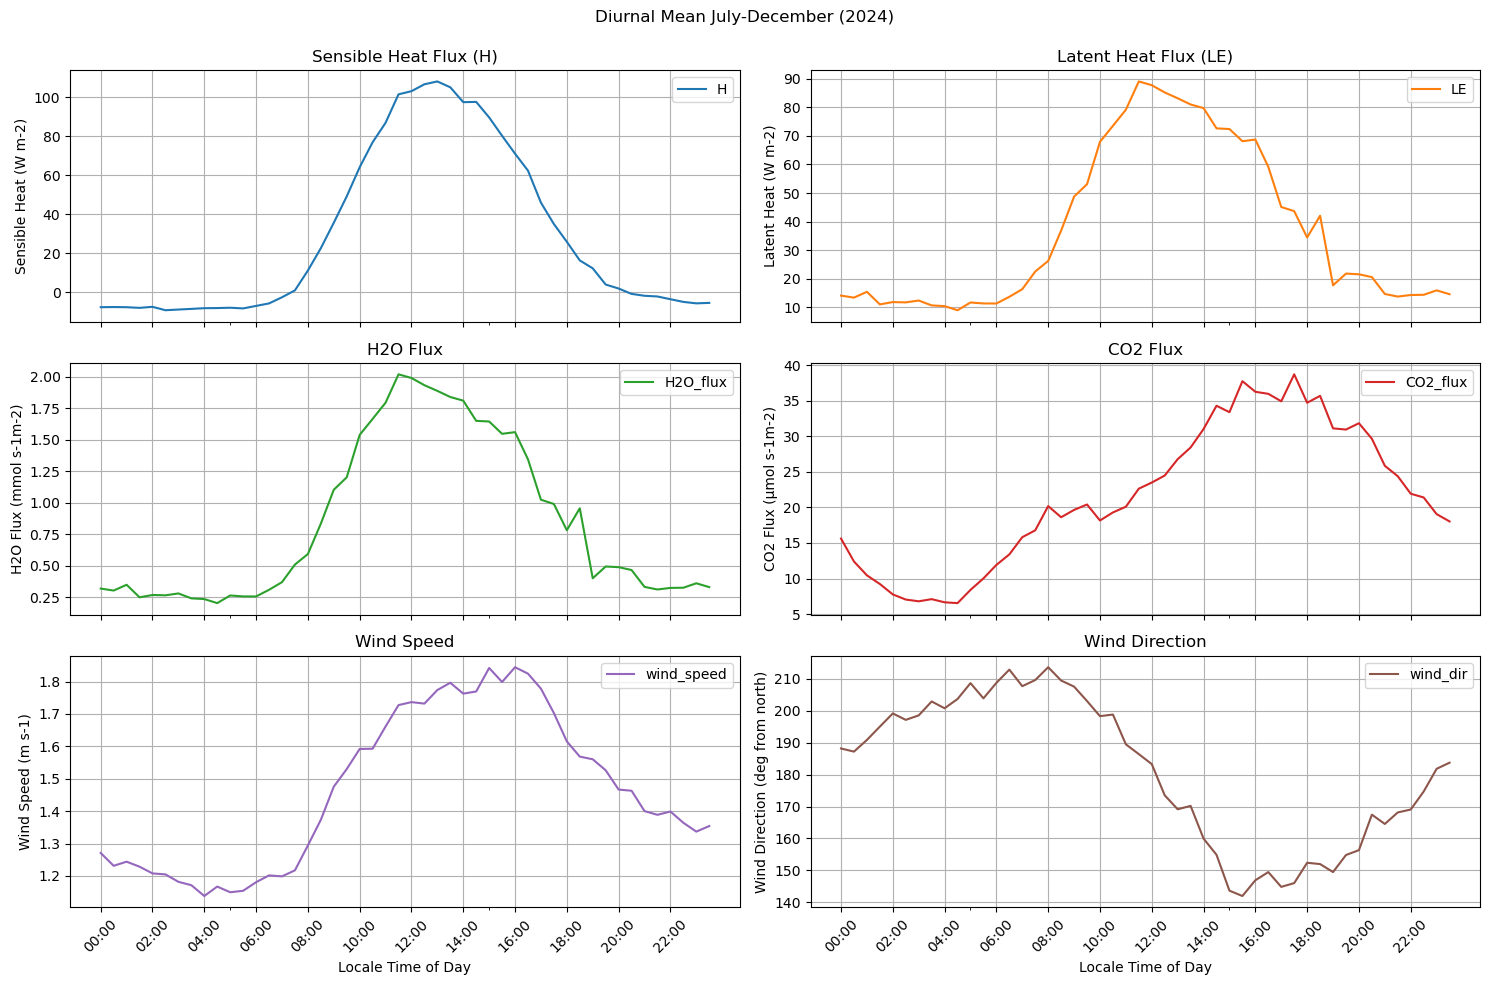

In [ ]:


axes = diurnal_means[['H', 'LE', 'H2O_flux', 'CO2_flux', 'wind_speed', 'wind_dir']].plot(
    subplots=True, 
    layout=(3, 2),  
    figsize=(15, 10), 
    grid=True,  
    sharex=True,  
)


axes[0, 0].set_title('Sensible Heat Flux (H)')
axes[0, 0].set_ylabel(f'Sensible Heat ({units["H"]})')

axes[0, 1].set_title('Latent Heat Flux (LE)')
axes[0, 1].set_ylabel(f'Latent Heat ({units["LE"]})')

axes[1, 0].set_title('H2O Flux')
axes[1, 0].set_ylabel(f'H2O Flux ({units["H2O_flux"]})')

axes[1, 1].set_title('CO2 Flux')
axes[1, 1].set_ylabel(f'CO2 Flux ({units["CO2_flux"]})')

axes[2, 0].set_title('Wind Speed')
axes[2, 0].set_ylabel(f'Wind Speed ({units["wind_speed"]})')

axes[2, 1].set_title('Wind Direction')
axes[2, 1].set_ylabel(f'Wind Direction ({units["wind_dir"]})')

for ax in axes.flatten():
    ax.set_xlabel('Locale Time of Day')
    ax.set_xticks(range(0, len(diurnal_means.index), 4))  
    ax.set_xticklabels(diurnal_means.index[::4], rotation=45)  

plt.tight_layout()
plt.subplots_adjust(top=0.92)  
plt.suptitle('Diurnal Mean July-December (2024)')
plt.show()


## Diurnal Means with Standard Deviation

This plot will display the mean diurnal pattern along with the standard deviation to capture variability.

Calculate mean and standard deviation by time of day

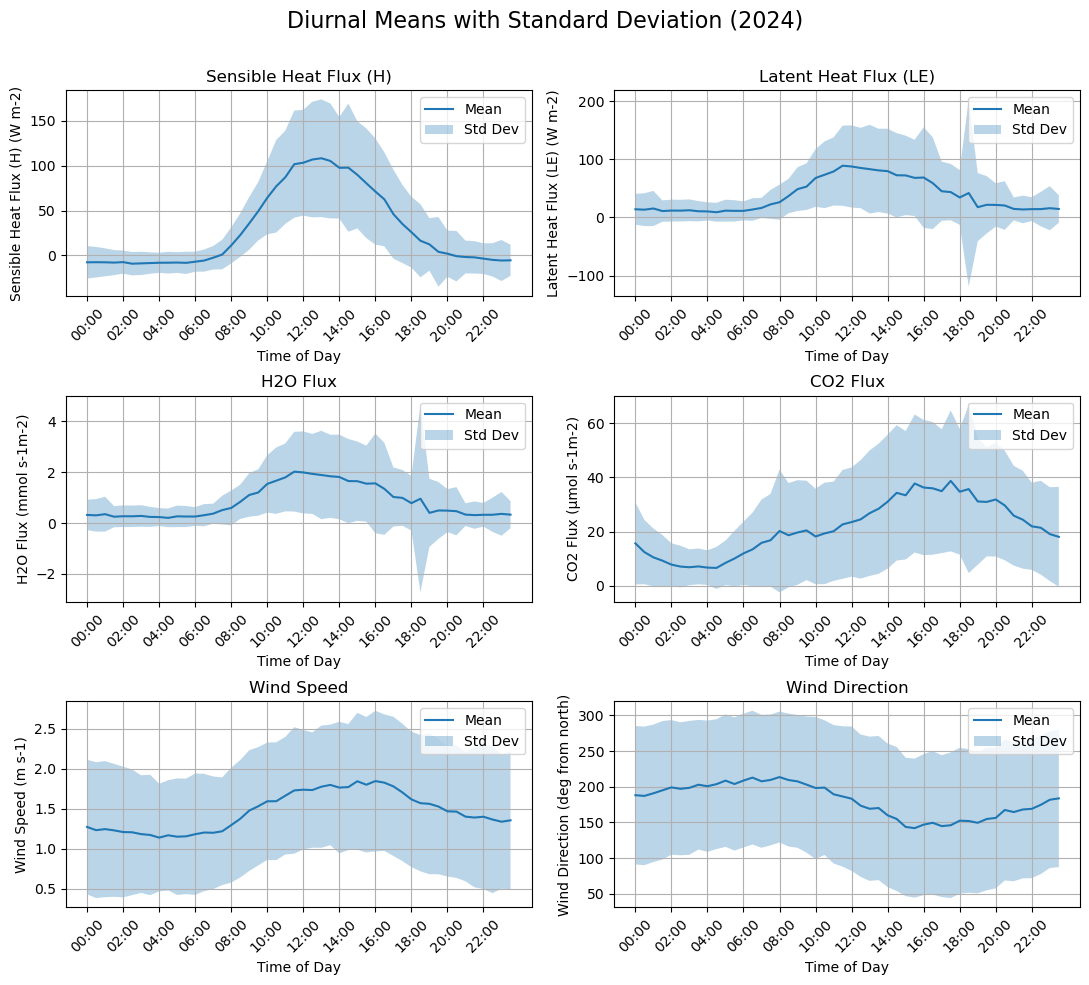

In [ ]:

diurnal_stats = df.groupby('time_of_day').agg(['mean', 'std'])
diurnal_stats = diurnal_stats.sort_index()

fig, axes = plt.subplots(3, 2, figsize=(11, 10))
fig.suptitle('Diurnal Means with Standard Deviation (2024)', fontsize=16)

variables = ['H', 'LE', 'H2O_flux', 'CO2_flux', 'wind_speed', 'wind_dir']
titles = ['Sensible Heat Flux (H)', 'Latent Heat Flux (LE)', 'H2O Flux', 'CO2 Flux', 'Wind Speed', 'Wind Direction']

for i, ax in enumerate(axes.flatten()):
    var = variables[i]
    ax.plot(diurnal_stats.index, diurnal_stats[var]['mean'], label='Mean')
    ax.fill_between(diurnal_stats.index, 
                    diurnal_stats[var]['mean'] - diurnal_stats[var]['std'], 
                    diurnal_stats[var]['mean'] + diurnal_stats[var]['std'], 
                    alpha=0.3, label='Std Dev')
    ax.set_title(titles[i])
    ax.set_xlabel('Time of Day')
    ax.set_ylabel(f'{titles[i]} ({units[var]})')
    ax.set_xticks(range(0, len(diurnal_stats.index), 4))
    ax.set_xticklabels(diurnal_stats.index[::4], rotation=45)
    ax.grid(True)
    ax.legend()

plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()


### percentiles for each time of day

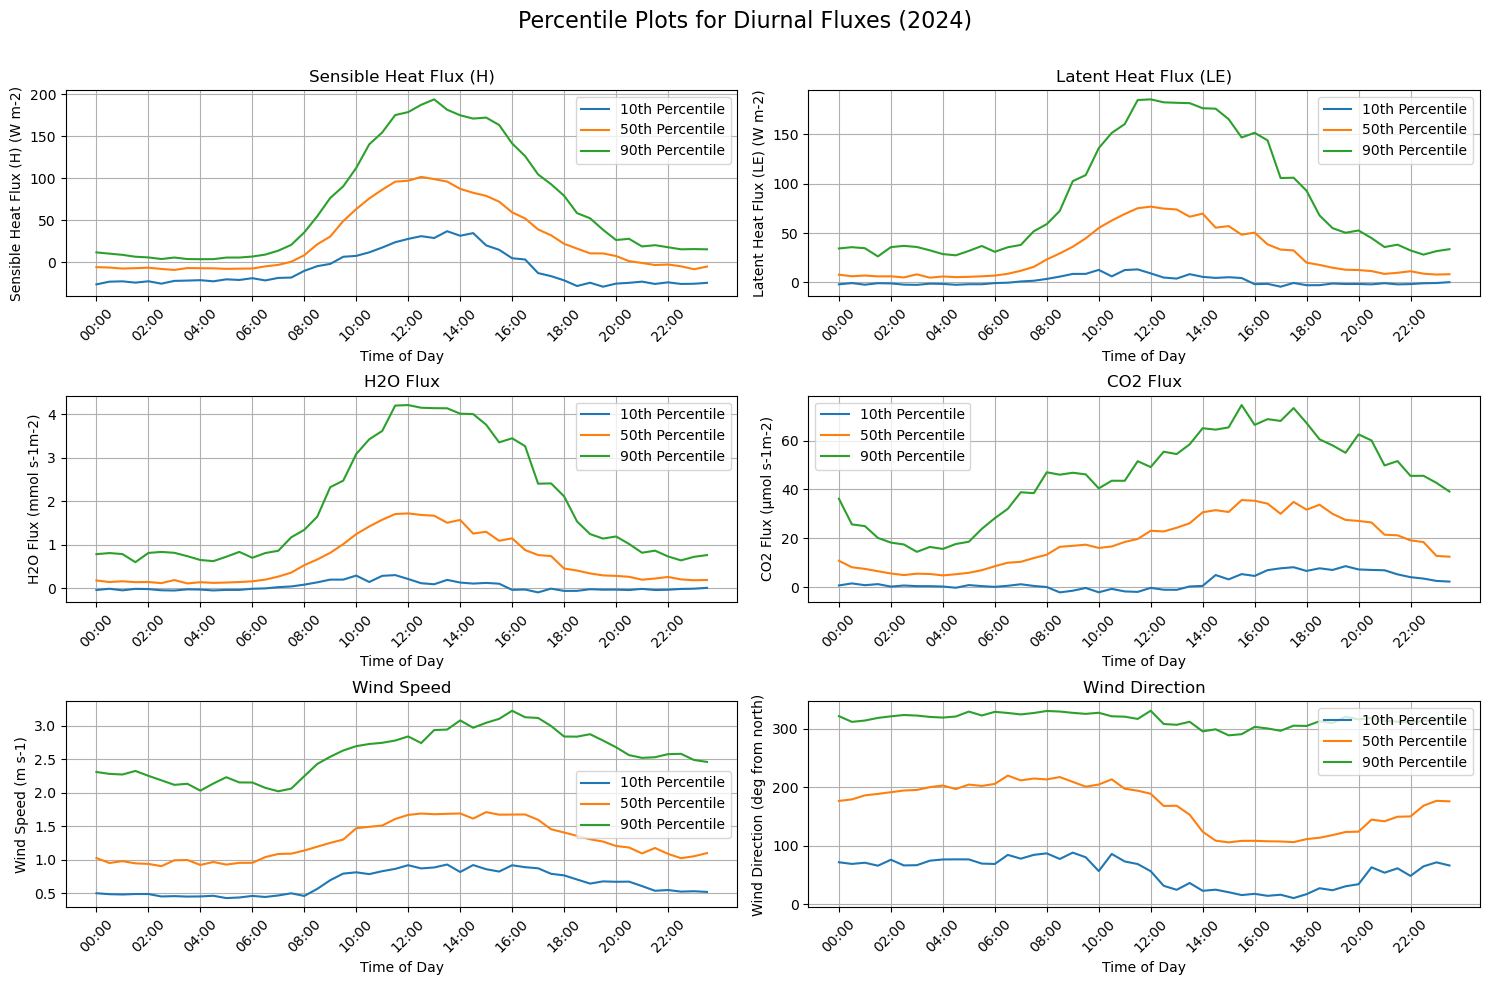

In [ ]:

percentiles = [10, 50, 90]
diurnal_percentiles = df.groupby('time_of_day').quantile([p / 100 for p in percentiles])
diurnal_percentiles = diurnal_percentiles.unstack(level=-1).sort_index()

fig, axes = plt.subplots(3, 2, figsize=(15, 10))
fig.suptitle('Percentile Plots for Diurnal Fluxes (2024)', fontsize=16)

for i, ax in enumerate(axes.flatten()):
    var = variables[i]
    for p in percentiles:
        ax.plot(diurnal_percentiles.index, diurnal_percentiles[(var, p / 100)], label=f'{p}th Percentile')
    ax.set_title(titles[i])
    ax.set_xlabel('Time of Day')
    ax.set_ylabel(f'{titles[i]} ({units[var]})')
    ax.set_xticks(range(0, len(diurnal_percentiles.index), 4))
    ax.set_xticklabels(diurnal_percentiles.index[::4], rotation=45)
    ax.grid(True)
    ax.legend()

plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()


/var/folders/c0/hb5cyy892hqdjht868lw3qk80000gp/T/ipykernel_59021/1952228964.py:44: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.15, 1, 0.95])


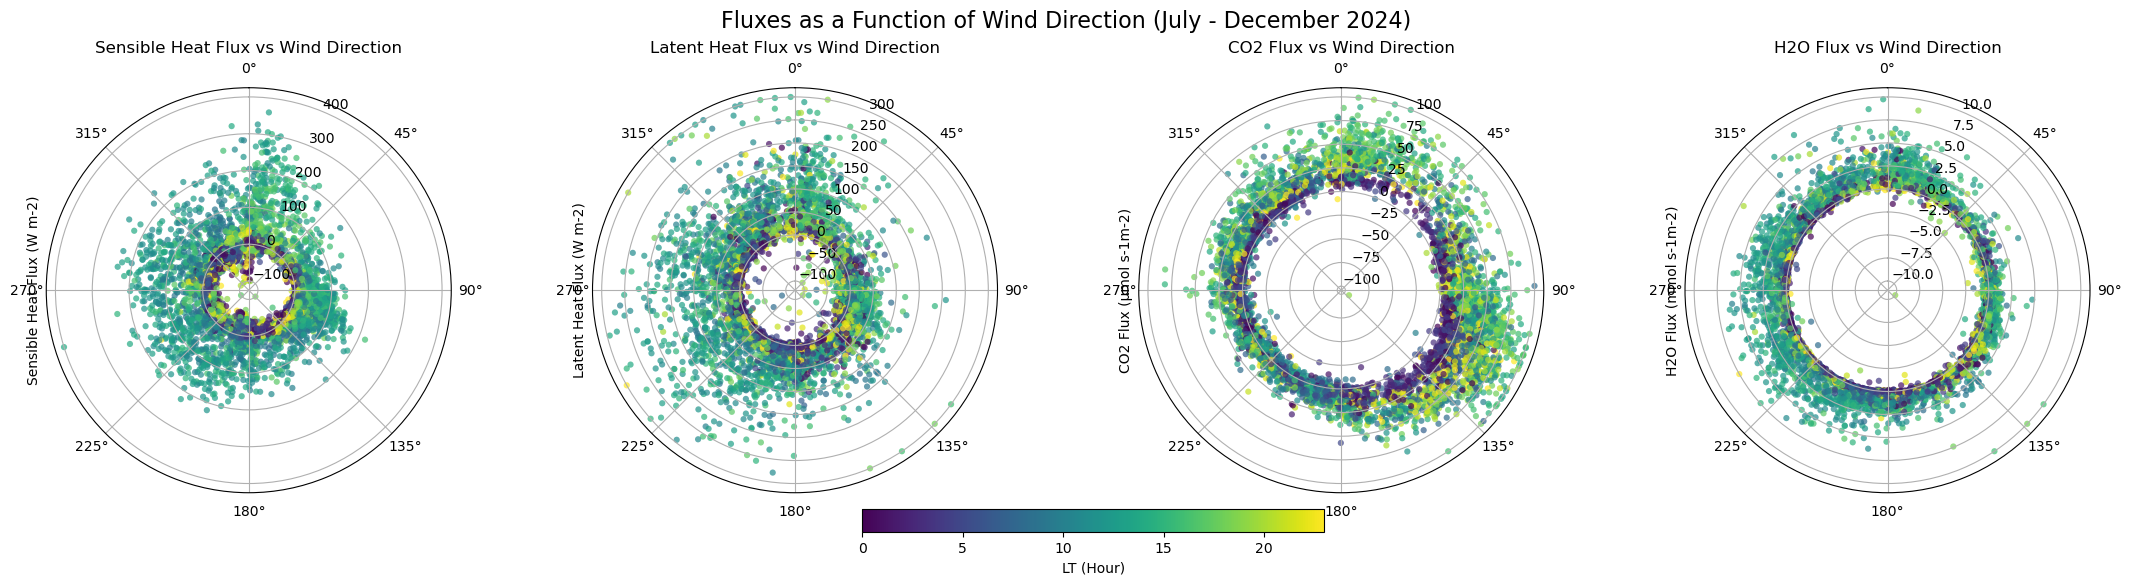

In [12]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 4, figsize=(22, 6), subplot_kw={'projection': 'polar'})
fig.suptitle('Fluxes as a Function of Wind Direction (July - December 2024)', fontsize=16)

flux_vars = ['H', 'LE', 'CO2_flux', 'H2O_flux']
flux_titles = ['Sensible Heat Flux', 'Latent Heat Flux', 'CO2 Flux', 'H2O Flux']

df['wind_dir_rad'] = np.deg2rad(df['wind_dir'])

norm = plt.Normalize(0, 23)  # Time of day goes from 0 23
sm = plt.cm.ScalarMappable(cmap='viridis', norm=norm)
sm.set_array([])

# Define limits for the flux values to control outliers
flux_limits = {
    'H': (-100, 400),           
    'LE': (-100, 300),          
    'CO2_flux': (-100, 100),     
    'H2O_flux': (-10, 10)      
}

for i, ax in enumerate(axes):
    var = flux_vars[i]
    lower, upper = flux_limits[var]
    clipped_data = df[var].clip(lower=lower, upper=upper)
    
    sc = ax.scatter(df['wind_dir_rad'], clipped_data, 
                    c=pd.to_datetime(df['time_of_day'], format='%H:%M').dt.hour, 
                    cmap='viridis', alpha=0.7, edgecolor='none', s=20, norm=norm)
    
    ax.set_title(f'{flux_titles[i]} vs Wind Direction')
    ax.set_ylabel(f'{flux_titles[i]} ({units[var]})')  
    ax.set_theta_zero_location('N') 
    ax.set_theta_direction(-1)  
    ax.grid(True)
    
cbar = fig.colorbar(sm, ax=axes, orientation='horizontal', fraction=0.05, pad=0.2)  
cbar.set_label('LT (Hour)')


plt.tight_layout(rect=[0, 0.15, 1, 0.95]) 
plt.subplots_adjust(top=0.85)
plt.show()


## Q-Q Plot
We grouped data by time of day (ignoring the date) to calculate the median values (50th percentile) for each variable separately for weekdays and weekends.

/var/folders/c0/hb5cyy892hqdjht868lw3qk80000gp/T/ipykernel_59021/2072665989.py:8: FutureWarning: Allowing bool dtype in DataFrameGroupBy.quantile is deprecated and will raise in a future version, matching the Series/DataFrame behavior. Cast to uint8 dtype before calling quantile instead.
  weekend_quantiles = df[df['is_weekend']].groupby('time_of_day').quantile(0.5)  # Median for weekends
/var/folders/c0/hb5cyy892hqdjht868lw3qk80000gp/T/ipykernel_59021/2072665989.py:9: FutureWarning: Allowing bool dtype in DataFrameGroupBy.quantile is deprecated and will raise in a future version, matching the Series/DataFrame behavior. Cast to uint8 dtype before calling quantile instead.
  weekday_quantiles = df[~df['is_weekend']].groupby('time_of_day').quantile(0.5)  # Median for weekdays
/var/folders/c0/hb5cyy892hqdjht868lw3qk80000gp/T/ipykernel_59021/2072665989.py:47: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(

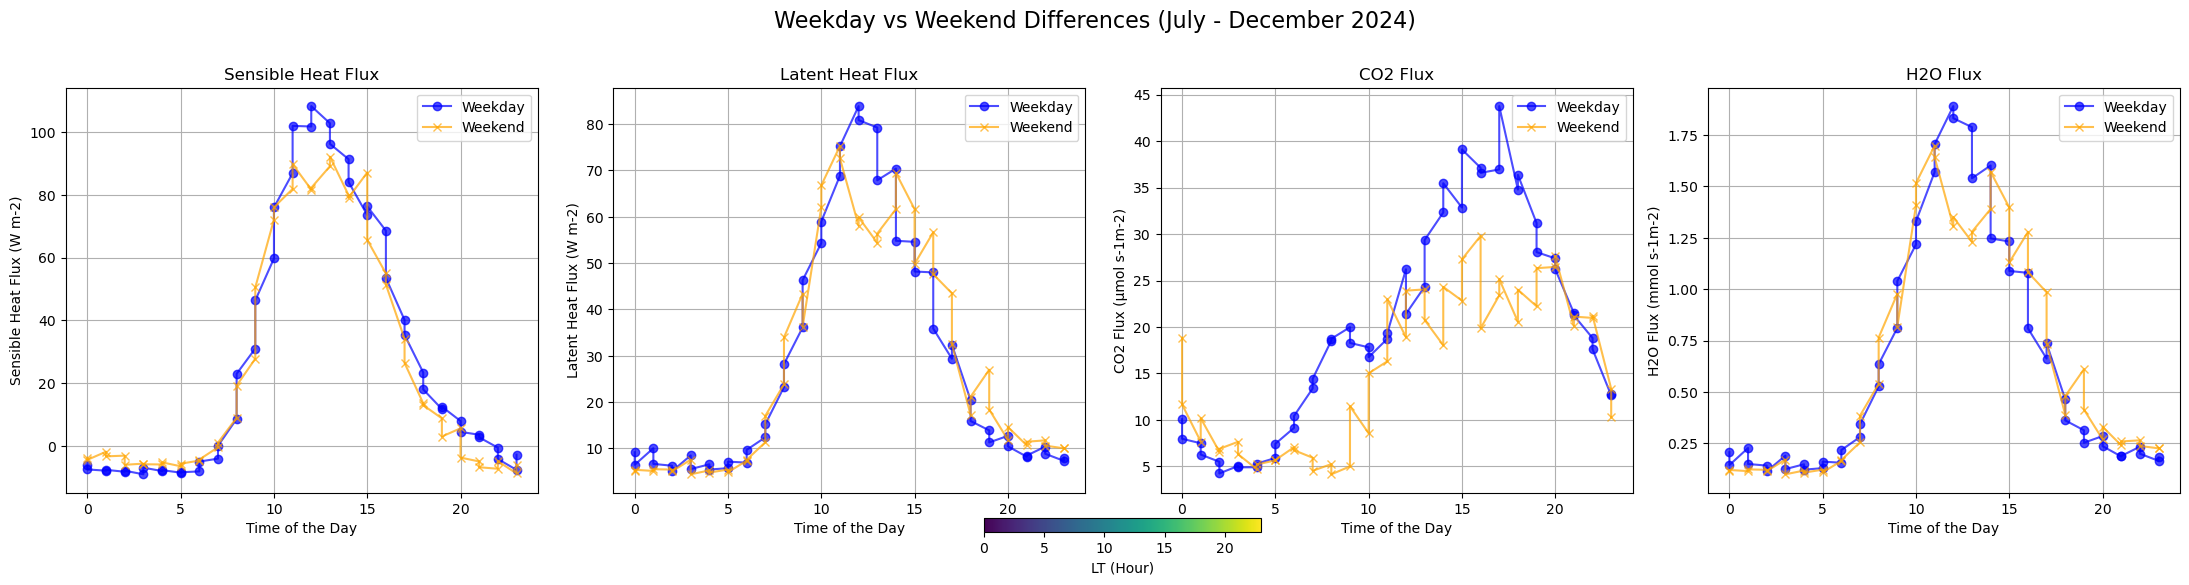

In [14]:
import matplotlib.pyplot as plt
from matplotlib import colors
import numpy as np

df['weekday'] = df['time'].dt.weekday
df['is_weekend'] = df['weekday'] >= 5

weekend_quantiles = df[df['is_weekend']].groupby('time_of_day').quantile(0.5)  # Median for weekends
weekday_quantiles = df[~df['is_weekend']].groupby('time_of_day').quantile(0.5)  # Median for weekdays

fig, axes = plt.subplots(1, 4, figsize=(22, 6))  # Adjusted to 4 subplots to include H2O Flux
fig.suptitle('Weekday vs Weekend Differences (July - December 2024)', fontsize=16)

flux_vars = ['H', 'LE', 'CO2_flux', 'H2O_flux']
flux_titles = ['Sensible Heat Flux', 'Latent Heat Flux', 'CO2 Flux', 'H2O Flux']


time_intervals = np.arange(0, 24, 1)  
norm = plt.Normalize(0, 23)  

sm = plt.cm.ScalarMappable(cmap='viridis', norm=norm)
sm.set_array([])

for i, ax in enumerate(axes):
    var = flux_vars[i]
    hours_of_day = pd.to_datetime(weekday_quantiles.index, format='%H:%M').hour
    
    ax.plot(hours_of_day, weekday_quantiles[var], marker='o', color='blue', label='Weekday', linestyle='-', alpha=0.7)
    ax.plot(hours_of_day, weekend_quantiles[var], marker='x', color='orange', label='Weekend', linestyle='-', alpha=0.7)
    
    # Add diagonal reference line
    #ax.plot([min(weekday_quantiles[var].min(), weekend_quantiles[var].min()), 
    #         max(weekday_quantiles[var].max(), weekend_quantiles[var].max())], 
    #        [min(weekday_quantiles[var].min(), weekend_quantiles[var].min()), 
    #         max(weekday_quantiles[var].max(), weekend_quantiles[var].max())], 
    #        color='red', linestyle='--')
    
    ax.set_title(f'{flux_titles[i]}')
    ax.set_xlabel(f'Time of the Day')
    ax.set_ylabel(f'{flux_titles[i]} ({units[var]})')
    ax.grid(True)
    ax.legend()

cbar = fig.colorbar(sm, ax=axes, orientation='horizontal', fraction=0.03, pad=0.1)
cbar.set_label('LT (Hour)')

plt.tight_layout(rect=[0, 0.15, 1, 0.95]) 
plt.subplots_adjust(top=0.85)
plt.show()


## add IQR to teh lpot

/var/folders/c0/hb5cyy892hqdjht868lw3qk80000gp/T/ipykernel_88889/3752474386.py:9: FutureWarning: Allowing bool dtype in DataFrameGroupBy.quantile is deprecated and will raise in a future version, matching the Series/DataFrame behavior. Cast to uint8 dtype before calling quantile instead.
  weekend_quantiles = df[df['is_weekend']].groupby('time_of_day').quantile([0.25, 0.5, 0.75])  # Q1, Median, Q3 for weekends
/var/folders/c0/hb5cyy892hqdjht868lw3qk80000gp/T/ipykernel_88889/3752474386.py:10: FutureWarning: Allowing bool dtype in DataFrameGroupBy.quantile is deprecated and will raise in a future version, matching the Series/DataFrame behavior. Cast to uint8 dtype before calling quantile instead.
  weekday_quantiles = df[~df['is_weekend']].groupby('time_of_day').quantile([0.25, 0.5, 0.75])  # Q1, Median, Q3 for weekdays


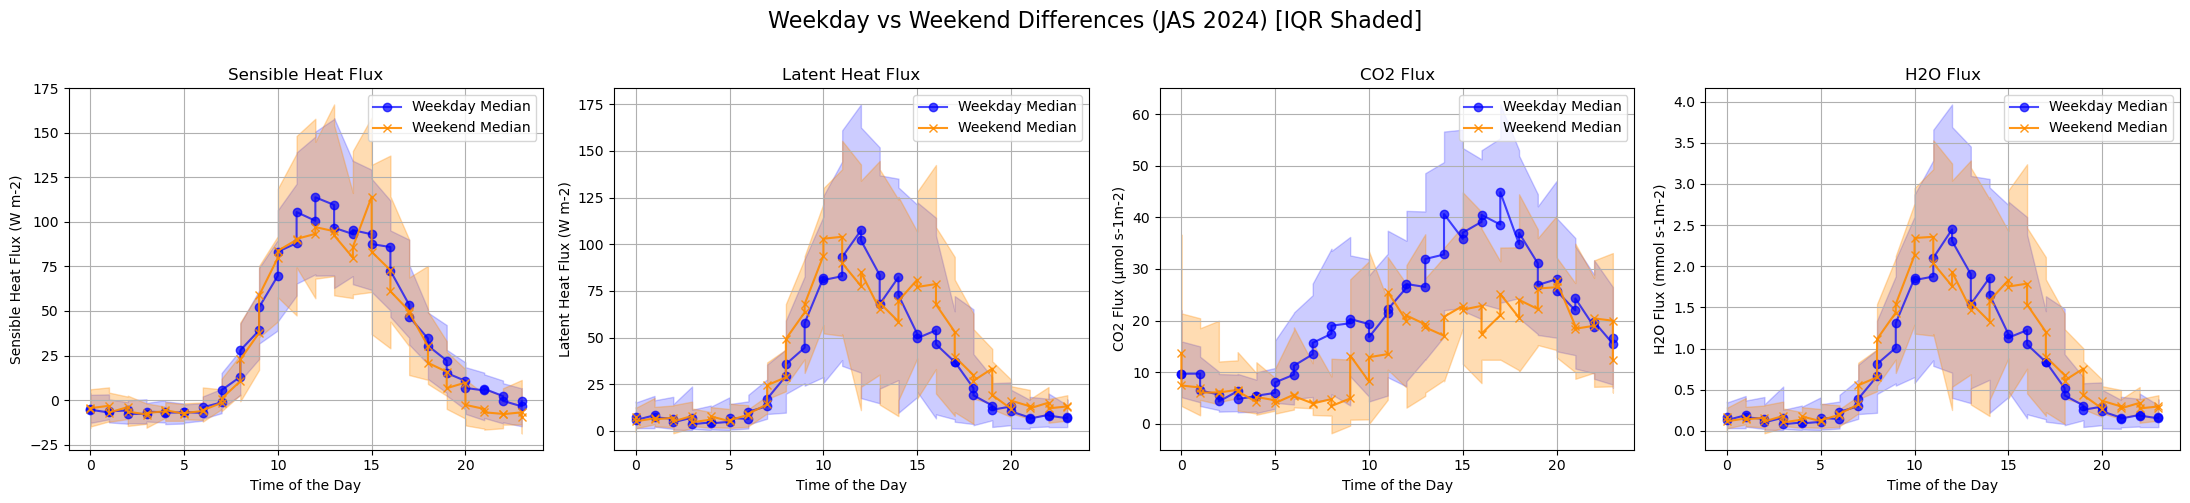

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

df['weekday'] = df['time'].dt.weekday
df['is_weekend'] = df['weekday'] >= 5

weekend_quantiles = df[df['is_weekend']].groupby('time_of_day').quantile([0.25, 0.5, 0.75])  # Q1, Median, Q3 for weekends
weekday_quantiles = df[~df['is_weekend']].groupby('time_of_day').quantile([0.25, 0.5, 0.75])  # Q1, Median, Q3 for weekdays


weekend_quantiles = weekend_quantiles.unstack(level=1)
weekday_quantiles = weekday_quantiles.unstack(level=1)


fig, axes = plt.subplots(1, 4, figsize=(22, 6))  
fig.suptitle('Weekday vs Weekend Differences (JAS 2024) [IQR Shaded]', fontsize=16)


flux_vars = ['H', 'LE', 'CO2_flux', 'H2O_flux']
flux_titles = ['Sensible Heat Flux', 'Latent Heat Flux', 'CO2 Flux', 'H2O Flux']

for i, ax in enumerate(axes):
    var = flux_vars[i]
    
    hours_of_day = pd.to_datetime(weekday_quantiles.index, format='%H:%M').hour
    

    ax.plot(hours_of_day, weekday_quantiles[(var, 0.5)], marker='o', color='blue', label='Weekday Median', linestyle='-', alpha=0.7)
    ax.fill_between(hours_of_day, weekday_quantiles[(var, 0.25)], weekday_quantiles[(var, 0.75)], color='blue', alpha=0.2)

    ax.plot(hours_of_day, weekend_quantiles[(var, 0.5)], marker='x', color='darkorange', label='Weekend Median', linestyle='-', alpha=0.9)
    ax.fill_between(hours_of_day, weekend_quantiles[(var, 0.25)], weekend_quantiles[(var, 0.75)], color='darkorange', alpha=0.3)
    
    ax.set_title(f'{flux_titles[i]}')
    ax.set_xlabel(f'Time of the Day')
    ax.set_ylabel(f'{flux_titles[i]} ({units[var]})')
    ax.grid(True)
    ax.legend()

plt.tight_layout(rect=[0, 0.15, 1, 0.95])
plt.subplots_adjust(top=0.85)
plt.show()


_Disclaimer: Argonne's AI chatbot ARGO helped in making these scripts._